<a href="https://colab.research.google.com/github/sak1b0/proteiNN/blob/master/CuDNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.layers import LSTM,Dropout,Masking,CuDNNLSTM
from keras import losses
from keras.optimizers import adam
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import time

prop = {1:[1.8,-0.17,0.11,0,0.38,-0.21,-1.6,0.42,-0.27,1.12,0.61],
18:[-4.5,-0.81,2.58,3.71,-2.57,2.11,12.3,-1.56,1.87,-2.55,0.6],
14:[-3.5,-0.42,2.05,3.47,-1.62,0.96,4.8,-1.03,0.81,-0.83,0.06],
4:[-3.5,-1.23,3.49,2.95,-3.27,1.36,9.2,-0.51,0.81,-0.83,0.46],
3:[2.5,0.24,-0.13,0.49,-0.3,-6.04,-2,0.84,-1.05,0.59,1.07],
17:[-3.5,-0.58,2.36,3.01,-1.84,1.52,4.1,-0.96,1.1,-0.78,0],
5:[-3.5,-2.02,2.68,1.64,-2.9,2.3,8.2,-0.37,1.17,-0.92,0.47],
7:[-0.4,-0.01,0.74,1.72,-0.19,0,-1,0,-0.16,1.2,0.07],
8:[-3.2,-0.96,2.06,4.76,-1.44,-1.23,3,-2.28,0.28,-0.93,0.61],
9:[4.5,0.31,-0.6,-1.56,1.97,-4.81,-3.1,1.81,-0.77,1.16,2.22],
12:[3.8,0.56,-0.55,-1.81,1.82,-4.68,-2.8,1.8,-1.1,1.18,1.53],
11:[-3.9,-0.99,2.71,5.39,-3.46,3.88,8.8,-2.03,1.7,-0.8,1.15],
13:[1.9,0.23,-0.1,-0.76,1.4,-3.66,-3.4,1.18,-0.73,0.55,1.18],
6:[2.8,1.13,-0.32,-2.2,1.98,-4.65,-3.7,1.74,-1.43,0.67,2.02],
16:[-1.6,-0.45,2.23,-1.52,-1.44,0.75,0.2,0.86,-0.75,0.54,1.95],
19:[-0.8,-0.13,0.84,1.83,-0.53,1.74,-0.6,-0.64,0.42,-0.05,0.05],
20:[-0.7,-0.14,0.52,1.78,-0.32,0.78,-1.2,-0.26,0.63,-0.02,0.05],
23:[-0.9,1.85,0.3,-0.38,1.53,-3.32,-1.9,1.46,-1.57,-0.19,2.65],
25:[-1.3,0.94,0.68,-1.09,0.49,-1.01,0.7,0.51,-0.56,-0.23,1.88],
22:[4.2,-0.07,-0.31,-0.78,1.46,-3.5,-2.6,1.34,-0.4,1.13,1.32],
26:[0,0,0,0,0,0,0,0,0,0,0]}

df_train=np.asarray(pd.read_csv('https://raw.githubusercontent.com/sak1b0/proteiNN/master/train_formatted.csv',header=None))
df_test=np.asarray(pd.read_csv('https://raw.githubusercontent.com/sak1b0/proteiNN/master/test_formatted.csv',header=None))

x_train = df_train[:,0]
y_train = df_train[:,1]

x_test = df_test[:,0]
y_test = df_test[:,1]

def debug_me():
  #print('train dataframe: ',df_train.shape)
  print('x_train shape: ',x_train.shape)
  print('y_train shape: ',y_train.shape)

  #print('test dataframe: ',df_test.shape)
  print('x_test shape: ',x_test.shape)
  print('y_test shape: ',y_test.shape)

max_len=400

#================== x_train ===============
n = x_train
j=-1

for i in x_train:
  j=j+1
  if(len(i)>max_len):
    n = np.delete(n, j)
    j=j-1

for item in range (len(n)):
  n[item] = n[item]+'Z'*(max_len-len(n[item]))

x_train = n

#================= y_train =================
n = y_train
j=-1

for i in y_train:
  j=j+1
  if(len(i)>max_len):
    n = np.delete(n, j)
    j=j-1

for item in range (len(n)):
  n[item] = n[item]+'Z'*(max_len-len(n[item]))
    
y_train = n
#=================  x_test ==================
n = x_test
j=-1

for i in x_test:
  j=j+1
  if(len(i)>max_len):
    n = np.delete(n, j)
    j=j-1

for item in range (len(n)):
  n[item] = n[item]+'Z'*(max_len-len(n[item]))

x_test = n
#=================  y_test ==================
n = y_test
j=-1

for i in y_test:
  j=j+1
  if(len(i)>max_len):
    n = np.delete(n, j)
    j=j-1

for item in range (len(n)):
  n[item] = n[item]+'Z'*(max_len-len(n[item]))

y_test = n

#============= selected data withing range===========


max_len = max([len(i) for i in x_train])
#print(max_len)

max_len = max([len(i) for i in y_test])
#print(max_len)

print('starting the preprocessing\n')
start_time = time.time()

#==============   Properties Encoded start  ============================

# ==========x_train conversion start====
s = list(x_train)

k = []

for i in range(len(s)):
  t=[]
  for item in range(len(s[i])):
    t.append(prop[ord(s[i][item])-64])
  k.append(t)


x_train = np.array(k)

#=========== x_train conversion end ====

#=========== x_test conversion start====
s = list(x_test)

k = []

for i in range(len(s)):
  t=[]
  for item in range(len(s[i])):
    t.append(prop[ord(s[i][item])-64])
  k.append(t)


x_test = np.array(k)

#============= x_test conversion end====


#==============   Properties Encoded end  ============================



#==============   ONE_HOT   ==========================================

#======= y_train start========
#y_train = y_train[0:3]

alphabet = 'CEHXZ'

char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

k = []

for i in range(len(y_train)):
  integer_encoded = [char_to_int[char] for char in y_train[i]]
  
  onehot_encoded=list()
  for value in integer_encoded:
	  letter = [0 for _ in range(len(alphabet))]
	  letter[value] = 1
	  onehot_encoded.append(letter)
  
  k.append(onehot_encoded)  

y_train = np.array(k)
#display(y_train)

#======= y_train end========

#======= y_test start========
#y_train = y_train[0:3]

alphabet = 'CEHXZ'

char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

k = []

for i in range(len(y_test)):
  integer_encoded = [char_to_int[char] for char in y_test[i]]
  
  onehot_encoded=list()
  for value in integer_encoded:
	  letter = [0 for _ in range(len(alphabet))]
	  letter[value] = 1
	  onehot_encoded.append(letter)
  
  k.append(onehot_encoded)  

y_test = np.array(k)
#display(y_train)

#======= y_test end========

#==============   ONE_HOT   finish ============================

print('ending the preprocessing\n')
finish_time=time.time()
print ('Time taken to pre-process: ',round(finish_time - start_time,2),' seconds')

#==============   ONE_HOT_INVERSION   ==================================
 
#for i in range(len(y_train[0])):
#  inverted = int_to_char[argmax(y_train[0][i])]
#  print(inverted)

#================ it's time to learn============================
debug_me()
start_time = time.time()
  
model=Sequential()

#model.add(Masking(mask_value=0, input_shape=(400, 11)))

model.add(CuDNNLSTM((128),batch_input_shape=(None,400,11),return_sequences=True))
#+model.add(Dropout(0.2))
model.add(BatchNormalization())





model.add(Dense(5,activation='softmax'))



model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['categorical_accuracy'])

model.summary()

print(model.input_shape)
print(model.output_shape)

history=model.fit(x_train,y_train,epochs=30,validation_data=(x_test,y_test))

finish_time=time.time()
print ('Time taken to train: ',round((finish_time - start_time)/60,2),' minutes')

starting the preprocessing

ending the preprocessing

Time taken to pre-process:  8.88  seconds
x_train shape:  (4061, 400, 11)
y_train shape:  (4061, 400, 5)
x_test shape:  (1058, 400, 11)
y_test shape:  (1058, 400, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 400, 128)          72192     
_________________________________________________________________
batch_normalization_3 (Batch (None, 400, 128)          512       
_________________________________________________________________
dense_3 (Dense)              (None, 400, 5)            645       
Total params: 73,349
Trainable params: 73,093
Non-trainable params: 256
_________________________________________________________________
(None, 400, 11)
(None, 400, 5)
Train on 4061 samples, validate on 1058 samples
Epoch 1/30
4061/4061 [==============================] - 10s 3ms/step - loss: 0.5848 - categorical_acc

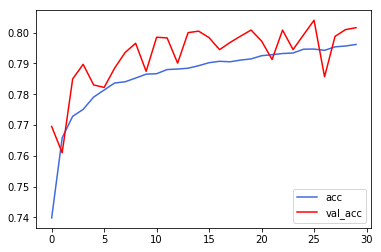

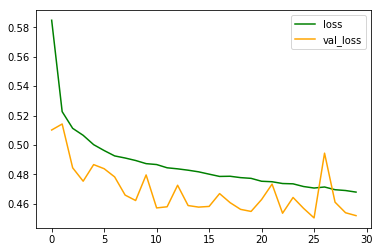

In [8]:
y_pred = model.predict(x_test)
#print(history.history.keys())
plt.plot(history.history['categorical_accuracy'],color='royalblue',label='acc')
plt.plot(history.history['val_categorical_accuracy'],color='red',label='val_acc')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'],color='green',label='loss')
plt.plot(history.history['val_loss'],color='orange',label='val_loss')
plt.legend(loc='upper right')
plt.show()

selected row:  176
C:  42448  of  71167
E:  23826  of  42906
H:  40201  of  69465
X:  2116  of  9005
Z:  230657  of  230657
C:  0.5964562226874816
E:  0.5553069500769123
H:  0.5787230979630029
X:  0.23498056635202666
Z:  1.0
[0.59645622 0.55530695 0.5787231  0.23498057 1.        ]


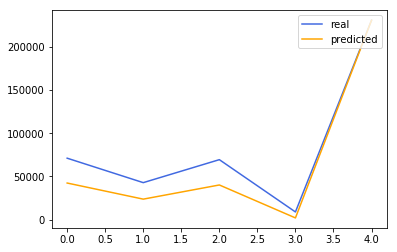

In [9]:
from numpy import argmax
import random as rnd
row=rnd.randint(1,800)
clm=rnd.randint(1,150)

print('selected row: ',row)

c_pred=0
c_actual=0

e_pred=0
e_actual=0

h_pred=0
h_actual=0

x_pred=0
x_actual=0

z_pred=0
z_actual=0


def controlz(p):
  global c_pred
  global c_actual

  global e_pred
  global e_actual

  global h_pred
  global h_actual

  global x_pred
  global x_actual

  global z_pred
  global z_actual
  for k in range(len(y_pred[p])):
    y = y_pred[p][k]
    m=-999
    mi=0
    for i in range(len(y)):
      if y[i]>m:
        m=y[i]
        mi=i
    
    for i in range(len(y)):
      y[i]=0

    y[mi]=1
  
    y_pred[p][k] = y
  
  a = list()
  b = list()
  count = 0
  corr = 0
  cc = 0
  cr = 0
  ec = 0
  er = 0
  hc = 0
  hr = 0
  xc = 0
  xr = 0
  zc = 0
  zr = 0
  for l in range(len(y_pred[p])):
    count = count+1
    a.insert(500, int_to_char[argmax(y_pred[p][l])])
    b.insert(500, int_to_char[argmax(y_test[p][l])])
    if int_to_char[argmax(y_test[p][l])] == 'C':
      cc = cc+1
      if int_to_char[argmax(y_pred[p][l])] == int_to_char[argmax(y_test[p][l])]:
        corr = corr+1
        cr = cr+1
    elif int_to_char[argmax(y_test[p][l])] == 'E':
      ec = ec+1
      if int_to_char[argmax(y_pred[p][l])] == int_to_char[argmax(y_test[p][l])]:
        corr = corr+1
        er = er+1
    elif int_to_char[argmax(y_test[p][l])] == 'H':
      hc = hc+1
      if int_to_char[argmax(y_pred[p][l])] == int_to_char[argmax(y_test[p][l])]:
        corr = corr+1
        hr = hr+1
    elif int_to_char[argmax(y_test[p][l])] == 'X':
      xc = xc+1
      if int_to_char[argmax(y_pred[p][l])] == int_to_char[argmax(y_test[p][l])]:
        corr = corr+1
        xr = xr+1
    elif int_to_char[argmax(y_test[p][l])] == 'Z':
      zc = zc+1
      if int_to_char[argmax(y_pred[p][l])] == int_to_char[argmax(y_test[p][l])]:
        corr = corr+1
        zr = zr+1
    
  #print('Length : ', count)
  #print('Correct: ', corr)
    
  #print('C : ', cr, '/', cc)
  #print('E : ', er, '/', ec)
  #print('H : ', hr, '/', hc)
  #print('X : ', xr, '/', xc)
  #print('Z : ', zr, '/', zc)
  c_pred=c_pred+cr
  c_actual=c_actual+cc
  
  e_pred=e_pred+er
  e_actual=e_actual+ec
  
  h_pred=h_pred+hr
  h_actual=h_actual+hc
  
  x_pred=x_pred+xr
  x_actual=x_actual+xc
  
  z_pred=z_pred+zr
  z_actual=z_actual+zc
  
    
  #print(a)
  #print(b)
    
#controlz(row)
#print(y_pred.shape)
for item in range(0,y_pred.shape[0]):
  controlz(item)

print('C: ',c_pred,' of ',c_actual)
print('E: ',e_pred,' of ',e_actual)
print('H: ',h_pred,' of ',h_actual)
print('X: ',x_pred,' of ',x_actual)
print('Z: ',z_pred,' of ',z_actual)

print('C: ',c_pred/c_actual)
print('E: ',e_pred/e_actual)
print('H: ',h_pred/h_actual)
print('X: ',x_pred/x_actual)
print('Z: ',z_pred/z_actual)

prob=[]
prob.append(c_pred/c_actual)
prob.append(e_pred/e_actual)
prob.append(h_pred/h_actual)
prob.append(x_pred/x_actual)
prob.append(z_pred/z_actual)

prob=np.array(prob)
print(prob)

pred=[]
real=[]

pred.append(c_pred)
pred.append(e_pred)
pred.append(h_pred)
pred.append(x_pred)
pred.append(z_pred)

real.append(c_actual)
real.append(e_actual)
real.append(h_actual)
real.append(x_actual)
real.append(z_actual)

plt.plot(real,color='royalblue',label='real')
plt.legend(loc='upper right')
#plt.show()

plt.plot(pred,color='orange',label='predicted')
plt.legend(loc='upper right')
plt.show()

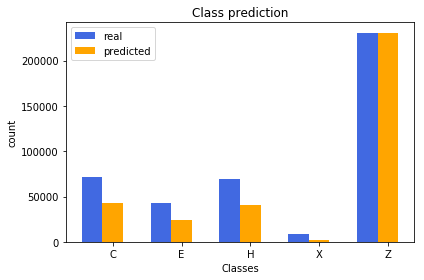

In [10]:
n_groups = 5


# create plot

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.30
opacity = 1.0

rects1 = plt.bar(index, real, bar_width,
alpha=opacity,
color='royalblue',
label='real')

rects2 = plt.bar(index + bar_width, pred, bar_width,
alpha=opacity,
color='orange',
label='predicted')


plt.xlabel('Classes')
plt.ylabel('count')
plt.title('Class prediction')
plt.xticks(index + bar_width, ('C', 'E', 'H', 'X','Z'))
plt.legend()

plt.tight_layout()
plt.show()